# Demo: Productive Compositional Generalization
#### Reproducing train/test splits from "On the generalization capacity of neural networks during generic multimodal reasoning" (ICLR 2024)

Note, that that this demo reproduces task inputs and targets that are converted to token IDs, rather than image pixels and natural language inputs.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from gcog.models import rnn, transformer
import gcog.task.config as config
import gcog.task.dataset_generator as datagen # DATASET objects
import gcog.task.task_generator as taskgen
from torch.utils.data import DataLoader
plt.rcParams['font.sans-serif'] = "Arial"
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Productive compositional generalization split -- example is to train on trees of depth 3, and test on depth 5 (CompTreeSubsets) (Fig. 5)



In [2]:
#### Productivite compositional generalization split
dataset = 'comptree' # comptree ~ compositional tree structure
traindepth = 3 # number of nodes to include; depth 3 
testdepth = 5 # number of nodes to include in the test set; depth 5 # note depth has to be odd, since the task cannot end with an if-then-else operator
train_distractors = 5 # number of distractors to 'train' on
test_distractors = 5 # number of distractors to 'test' on. (since this is not the distractor split, we can just choose the same number of distractors)
ntrials = 5000 # number of randomly-sampled trials PER task operator
location_sampling = True # when randomly sampling object features, randomly sample from all possible locations (i.e., red 'a' at location (1,1))
nfeatures = 10 # number of object features to limit the model (i.e., only 10 colors and 10 shapes = 100 total color x shape combinations)

train_dataset = datagen.CompTreeDataset(tree_depth=traindepth,
                                        n_distractors=train_distractors,
                                        distractor_range=True,
                                        location=location_sampling,
                                        ntrials=ntrials,
                                        nfeatures=nfeatures)

test_dataset = datagen.CompTreeDataset(tree_depth=testdepth,
                                       n_distractors=test_distractors,
                                       distractor_range=True,
                                       location=location_sampling,
                                       ntrials=ntrials,
                                       nfeatures=nfeatures)

                                    

#### Print dataset statistics

In [3]:
print('Number of trials/samples:', len(train_dataset)) # Number of task operators (8) * ntrials

Number of trials/samples: 40000


#### Initialize dataloader (and simulate forward inference)

In [4]:
## Demonstration with just the trainloader; identical format with testloader

opsys_trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

# Retrieve batch from dataloader 
# rule inputs are the task instruction input
# stim_inputs are the binarized stimulus input
# target_outputs are the output label (for classification task)
# task_ordering: for now, disregard task_ordering; it's not necessary
rule_inputs, stim_inputs, target_outputs, task_ordering = next(iter(opsys_trainloader)) 

# Rule and stim inputs have +1, to include the EOS token
print('Size of rule inputs:', rule_inputs.shape) # batch_size x task tree length (rule sequence/tokens) x rule embedding 
print('Size of stim inputs:', stim_inputs.shape) # batch_size x image sequence/tokens (grid size is 10x10) x feature embedding x 1 image
print('Size of target output:', target_outputs.shape) # batch_size, ranges from 1-138 (possible decision outputs/vocabulary)
## Outputs can be:
# Bool: True or False statement
# Location tuple: 100 possible locations on a 10x10 grid
# Shape identity: The identity of 26 possible shapes
# Color identity: The identity of 10 possible colors
# all together 138 possible output classifications

# Initialize two models:
# RNN
model_rnn = rnn.RNN(num_hidden=512)
outputs, hn = model_rnn(rule_inputs.float(),stim_inputs.float())

# Perceiver
model_perceiver = transformer.Perceiver(nhead=1,embedding_dim=256,num_hidden=512)
outputs, hn = model_perceiver(rule_inputs.float(),stim_inputs.float())

Size of rule inputs: torch.Size([64, 5, 8])
Size of stim inputs: torch.Size([64, 101, 3, 1])
Size of target output: torch.Size([64])


#### Visualize example trials from train and test datasets

Instruction: [ if current yellow j + current purple i sum is odd , then color of current b , else shape of current purple object ]
Target output: cyan
Instruction: [ if current blue j sum is even , then [ if current red f product is even , then current cyan d sum is even , else current cyan a * current yellow g product is even ] , else [ if current white f + current orange y sum is even , then current brown g product is odd , else shape of current green object ] ]
Target output: False


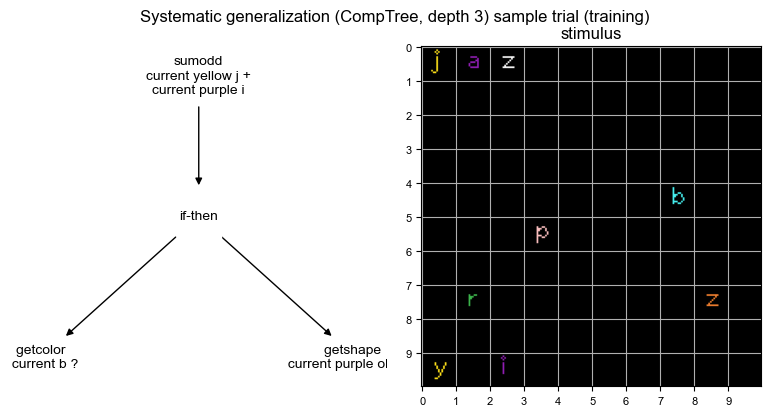

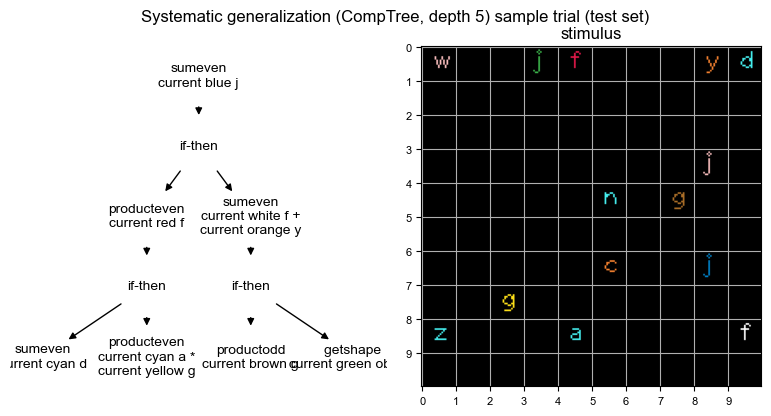

In [5]:
trial_idx = np.random.randint(0,len(train_dataset))
#### TRAINING SAMPLE
# Randomly select a trial number
# Extract the 'metatask' tree from dataset
metatask_train = train_dataset.metatasks[trial_idx]

# Generate stimuli
objset = metatask_train.generate_objset(n_distractor=train_distractors)
# Retrieve target label 
targets = metatask_train.get_target(objset)

print('Instruction:', metatask_train)
print('Target output:', targets[0])
img_array = objset.create_img()

plt.figure(figsize=(8,4))
plt.suptitle('Systematic generalization (CompTree, depth 3) sample trial (training)')
plt.subplot(121)
metatask_train.task_graph.plot_graph()
plt.tight_layout()

plt.subplot(122)
plt.title('stimulus',fontsize=12,fontname='Arial')
plt.imshow(np.asarray(img_array[:,:,:,0],dtype='int16'))
plt.grid()
plt.xticks(np.arange(0,200,20),np.arange(0,10),fontsize=8,fontname='Arial');
plt.yticks(np.arange(0,200,20),np.arange(0,10),fontsize=8,fontname='Arial');


#### TESTSET SAMPLE
# Extract the 'metatask' tree from dataset
metatask_test = test_dataset.metatasks[trial_idx]

# Generate stimuli
objset = metatask_test.generate_objset(n_distractor=test_distractors)
# Retrieve target label 
targets = metatask_test.get_target(objset)

print('Instruction:', metatask_test)
print('Target output:', targets[0])
img_array = objset.create_img()

plt.figure(figsize=(8,4))
plt.suptitle('Systematic generalization (CompTree, depth 5) sample trial (test set)')
plt.subplot(121)
metatask_test.task_graph.plot_graph()
plt.tight_layout()

plt.subplot(122)
plt.title('stimulus',fontsize=12,fontname='Arial')
plt.imshow(np.asarray(img_array[:,:,:,0],dtype='int16'))
plt.grid()
plt.xticks(np.arange(0,200,20),np.arange(0,10),fontsize=8,fontname='Arial');
plt.yticks(np.arange(0,200,20),np.arange(0,10),fontsize=8,fontname='Arial');